# Prepare Data

### Import

In [1]:
#from glob import glob

#Handling data
import pandas as pd 

#Vizualization
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

#Handle categorical features
from categorical_tiers import categorize_exterior1st, categorize_exterior2nd, categorize_neighborhood

#Interactive vizualization
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

#Encoding
from category_encoders import OneHotEncoder

#Model
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


In [2]:
#Create a wrangle function
def wrangle(filepath):

    #Func to drop columns with more than 100 missing data
    def drop_sparse_columns(df, threshold = 100):
        cols_to_drop = df.columns[df.isnull().sum()>threshold]
        df.drop(columns=cols_to_drop, inplace=True)
        return df
    
    #Read the data into a DataFrame
    df = pd.read_csv(filepath)

    #Drop columns with more than 100 missing data
    df = drop_sparse_columns(df,threshold=100)

    # Fill numeric columns where missing means 0
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

    # Fill basement categorical columns with 'None'
    bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    for col in bsmt_cols:
        df[col] = df[col].fillna('None')

    # Fill garage categorical columns with 'None'
    garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    for col in garage_cols:
        df[col] = df[col].fillna('None')

    # Fill Electrical with mode
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

    #Features Engineering
    df["TotalBath"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"]+ 0.5 * df["BsmtHalfBath"]
    df["TotalPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    df["AgeOfHouse"] = df["YrSold"]- df["YearBuilt"]
    df["YearsSinceRemod"] = df["YrSold"] - df["YearRemodAdd"]
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df.loc[df['GarageYrBlt'] == 0, 'GarageAge'] = 0
    df['TotalHouseSF'] = df['GrLivArea'] + df['TotalBsmtSF']

    #other features
    df['OverallGrade'] = df['OverallQual'] * df['OverallCond']
    df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['LowQualFinSF']
    




    #Columns to drop
    cols_to_drop = [
        'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
        'GrLivArea', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'FullBath','HalfBath',
        'OverallQual', 'OverallCond', 'BsmtFinSF1','BsmtUnfSF','BsmtFinSF2', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GarageCars'
    ]
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

    #Reset index
    df.set_index("Id", inplace=True)

    #Remove outliers by '"surface_area_covered"'
    low,high=df["LotArea"].quantile([0.1,0.9])
    mask_area=df["LotArea"].between(low,high)
    df=df[mask_area]

    #Cardinality
    df['Neighborhood_Tier'] = df['Neighborhood'].apply(categorize_neighborhood)
    df['Exterior1st_Tier'] = df['Exterior1st'].apply(categorize_exterior1st)
    df['Exterior2nd_Tier'] = df['Exterior2nd'].apply(categorize_exterior2nd)

    #Drop high cardinal features
    df.drop(columns=["Neighborhood", "Exterior1st", "Exterior2nd"], inplace= True)
    #Return the DataFrame
    return df

In [3]:
#Read data
df = wrangle("train.csv")

#Display the shape of the data
print(df.shape)

#Display info
df.info()

#Display the head of the data
df.head()

(1172, 57)
<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 1 to 1460
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1172 non-null   int64  
 1   MSZoning           1172 non-null   object 
 2   LotArea            1172 non-null   int64  
 3   Street             1172 non-null   object 
 4   LotShape           1172 non-null   object 
 5   LandContour        1172 non-null   object 
 6   Utilities          1172 non-null   object 
 7   LotConfig          1172 non-null   object 
 8   LandSlope          1172 non-null   object 
 9   Condition1         1172 non-null   object 
 10  Condition2         1172 non-null   object 
 11  BldgType           1172 non-null   object 
 12  HouseStyle         1172 non-null   object 
 13  RoofStyle          1172 non-null   object 
 14  RoofMatl           1172 non-null   object 
 15  MasVnrArea         1172 non-null   float64
 16  ExterQual         

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,...,TotalPorchSF,AgeOfHouse,YearsSinceRemod,GarageAge,TotalHouseSF,OverallGrade,TotalSF,Neighborhood_Tier,Exterior1st_Tier,Exterior2nd_Tier
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,...,61,5,5,5.0,2566,35,1710,High,Premium,Premium
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Feedr,...,0,31,31,31.0,2524,48,1262,High,Mid,Mid
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,...,42,7,6,7.0,2706,35,1786,High,Premium,Premium
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,...,307,91,36,8.0,2473,35,1717,High,Mid,High
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,Norm,...,84,8,8,8.0,3343,40,2198,Premium,Premium,Premium


In [4]:
df['Electrical'].unique()


array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

### Explore

In [5]:
df["SalePrice"].describe()

count      1172.000000
mean     176632.412969
std       71935.262488
min       34900.000000
25%      128987.500000
50%      159500.000000
75%      208350.000000
max      611657.000000
Name: SalePrice, dtype: float64

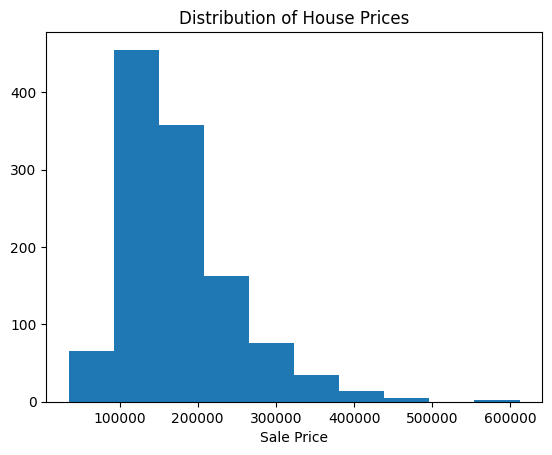

In [6]:
plt.hist(df["SalePrice"])
plt.xlabel("Sale Price")
plt.title("Distribution of House Prices");

In [7]:
fig = px.box(
    df,
    x="LotArea",
    title= "Distribution of LotArea",
    width= 1000,
    height= 600
)
fig.update_layout(
    title={
        "text":"Distribution of LotArea",
        "x":0.5,
        "xanchor":"center",
        "font":{"size":30}
    }

)
fig.show()

In [8]:
df["LotArea"].describe()

count     1172.000000
mean      9547.709898
std       2158.671490
min       5000.000000
25%       8024.750000
50%       9468.500000
75%      11053.750000
max      14375.000000
Name: LotArea, dtype: float64

In [9]:
df.select_dtypes("object").nunique()

MSZoning             5
Street               2
LotShape             4
LandContour          4
Utilities            2
LotConfig            5
LandSlope            3
Condition1           9
Condition2           6
BldgType             5
HouseStyle           8
RoofStyle            5
RoofMatl             5
ExterQual            4
ExterCond            5
Foundation           6
BsmtQual             5
BsmtCond             5
BsmtExposure         5
BsmtFinType1         7
BsmtFinType2         7
Heating              6
HeatingQC            5
CentralAir           2
Electrical           5
KitchenQual          4
Functional           6
GarageType           7
GarageFinish         4
GarageQual           6
GarageCond           6
PavedDrive           3
SaleType             9
SaleCondition        6
Neighborhood_Tier    4
Exterior1st_Tier     4
Exterior2nd_Tier     4
dtype: int64

In [10]:
sorted(df.columns)

['AgeOfHouse',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st_Tier',
 'Exterior2nd_Tier',
 'Fireplaces',
 'Foundation',
 'Functional',
 'GarageAge',
 'GarageArea',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotArea',
 'LotConfig',
 'LotShape',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'Neighborhood_Tier',
 'OverallGrade',
 'PavedDrive',
 'PoolArea',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SalePrice',
 'SaleType',
 'Street',
 'TotRmsAbvGrd',
 'TotalBath',
 'TotalHouseSF',
 'TotalPorchSF',
 'TotalSF',
 'Utilities',
 'WoodDeckSF',
 'YearsSinceRemod',
 'YrSold']

##### Check for multicolinearity

In [11]:
corr = df.select_dtypes("number").drop(columns="SalePrice").corr()
corr


,MSSubClass,LotArea,MasVnrArea,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,PoolArea,MiscVal,MoSold,YrSold,TotalBath,TotalPorchSF,AgeOfHouse,YearsSinceRemod,GarageAge,TotalHouseSF,OverallGrade,TotalSF
MSSubClass,1.000000,-0.098653,-0.008479,0.268739,0.054911,-0.065410,0.002023,-0.001426,-0.007517,0.026768,-0.012337,0.198652,0.057547,0.115302,0.012233,-0.017954,0.057786,0.061730,0.260022
LotArea,-0.098653,1.000000,0.282674,0.337323,0.274961,0.344511,0.188372,0.008989,0.037639,-0.025261,-0.009743,0.284156,0.071849,-0.261647,-0.183167,-0.132250,0.420043,0.174244,0.387681
MasVnrArea,-0.008479,0.282674,1.000000,0.314701,0.298512,0.389496,0.161799,-0.010717,-0.029063,0.024481,-0.000860,0.302903,0.058317,-0.316549,-0.167366,-0.203374,0.461908,0.228541,0.392074
TotRmsAbvGrd,0.268739,0.337323,0.314701,1.000000,0.303589,0.312483,0.148154,-0.028814,-0.031468,0.044457,-0.014025,0.464176,0.149487,-0.155198,-0.232479,-0.171421,0.668839,0.284768,0.832095
Fireplaces,0.054911,0.274961,0.298512,0.303589,1.000000,0.237854,0.187418,0.027930,-0.021076,0.046984,-0.007284,0.307168,0.163005,-0.186821,-0.118928,-0.024564,0.441065,0.298856,0.442845
GarageArea,-0.065410,0.344511,0.389496,0.312483,0.237854,1.000000,0.208984,-0.008532,-0.043796,0.031368,-0.011187,0.435360,0.077634,-0.526373,-0.405158,-0.353776,0.536209,0.332577,0.432621
WoodDeckSF,0.002023,0.188372,0.161799,0.148154,0.187418,0.208984,1.000000,0.050329,-0.025615,0.021794,0.053336,0.287308,-0.084487,-0.243235,-0.238543,-0.218171,0.273182,0.189764,0.230767
PoolArea,-0.001426,0.008989,-0.010717,-0.028814,0.027930,-0.008532,0.050329,1.000000,-0.003550,-0.038701,-0.028398,0.005468,-0.034709,-0.009191,-0.011192,0.004241,-0.014007,0.010781,-0.023587
MiscVal,-0.007517,0.037639,-0.029063,-0.031468,-0.021076,-0.043796,-0.025615,-0.003550,1.000000,-0.020081,0.014880,-0.052914,-0.007803,0.037876,0.003675,0.025302,-0.047570,0.051394,-0.041214
MoSold,0.026768,-0.025261,0.024481,0.044457,0.046984,0.031368,0.021794,-0.038701,-0.020081,1.000000,-0.165638,0.021922,0.037132,-0.041048,-0.041154,-0.029656,0.067196,0.035885,0.073813


### Split

In [12]:
target = "SalePrice"
features = df.drop(columns="SalePrice", axis=1)
y_train = df[target]
X_train = features

# Build Model


### Baseline

In [13]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)

print(f"Mean Apt Price: {round(y_mean,2)}")
print(f"Basline Mae: {mean_absolute_error(y_train, y_pred_baseline)}")

Mean Apt Price: 176632.41
Basline Mae: 53961.514490559006


### Iterate

##### Encoding

In [14]:
#Instantiate
ohe = OneHotEncoder(use_cat_names=True)

#Fit
ohe.fit(X_train)

#Transform
XT_train = ohe.transform(X_train)

print(XT_train.shape)
XT_train.head()

(1172, 207)


,MSSubClass,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotArea,Street_Pave,Street_Grvl,LotShape_Reg,...,Neighborhood_Tier_Mid,Neighborhood_Tier_Low,Exterior1st_Tier_Premium,Exterior1st_Tier_Mid,Exterior1st_Tier_High,Exterior1st_Tier_Low,Exterior2nd_Tier_Premium,Exterior2nd_Tier_Mid,Exterior2nd_Tier_High,Exterior2nd_Tier_Low
Id,,,,,,,,,,,,,,,,,,,,,
1,60,1,0,0,0,0,8450,1,0,1,...,0,0,1,0,0,0,1,0,0,0
2,20,1,0,0,0,0,9600,1,0,1,...,0,0,0,1,0,0,0,1,0,0
3,60,1,0,0,0,0,11250,1,0,0,...,0,0,1,0,0,0,1,0,0,0
4,70,1,0,0,0,0,9550,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5,60,1,0,0,0,0,14260,1,0,0,...,0,0,1,0,0,0,1,0,0,0


##### Model

In [15]:
#Make pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy="mean"),
    Ridge()
)
#Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['MSZoning', 'Street', 'LotShape',
                                     'LandContour', 'Utilities', 'LotConfig',
                                     'LandSlope', 'Condition1', 'Condition2',
                                     'BldgType', 'HouseStyle', 'RoofStyle',
                                     'RoofMatl', 'ExterQual', 'ExterCond',
                                     'Foundation', 'BsmtQual', 'BsmtCond',
                                     'BsmtExposure', 'BsmtFinType1',
                                     'BsmtFinType2', 'Heating', 'HeatingQC',
                                     'CentralAir', 'Electrical', 'KitchenQual',
                                     'Functional', 'GarageType', 'GarageFinish',
                                     'GarageQual', ...],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [16]:
check_is_fitted(model[-1])

### Evaluate

In [17]:
# Calculate the training mean absolute error for your predictions as compared to the true targets in y_train
y_pred_training = model.predict(X_train)
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_training)}")

Training MAE: 13047.242917937536


##### Import test data

In [19]:
X_test = pd.read_csv("test_cleaned.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    105175.565456
1    186594.004873
2    195851.232792
3    206766.910191
4    170321.720585
dtype: float64

In [21]:
test_raw = pd.read_csv("test.csv")


In [22]:
submission = pd.DataFrame({
    "Id": test_raw["Id"],  # make sure test has 'Id'
    "SalePrice": y_pred_test  # your model's predictions
})
submission.to_csv("submission.csv", index=False)


# Communicate Results

In [24]:
coefficients =model.named_steps["ridge"].coef_
features =model.named_steps['onehotencoder'].get_feature_names_out()
feat_imp =pd.Series(coefficients,index=features)
feat_imp.tail()

Exterior1st_Tier_Low       -1042.499757
Exterior2nd_Tier_Premium   -2002.596960
Exterior2nd_Tier_Mid        3607.230882
Exterior2nd_Tier_High      -2096.396876
Exterior2nd_Tier_Low         491.762954
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

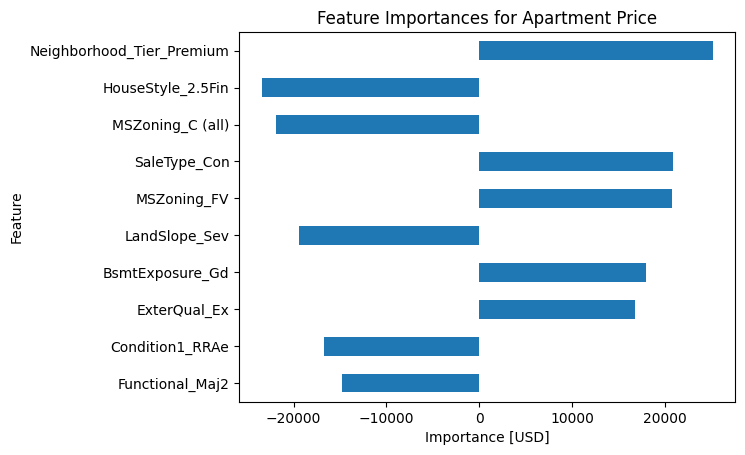

In [26]:
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")


# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price")




In [30]:
import plotly.graph_objects as go

top_features = feat_imp.abs().sort_values().tail(10)

fig = go.Figure(go.Bar(
    x=top_features.values,
    y=top_features.index,
    orientation='h'
))

fig.update_layout(
    title="Feature Importances for Apartment Price",
    xaxis_title="Importance [USD]",
    yaxis_title="Feature",
    yaxis=dict(autorange="reversed")  # highest at top
)

fig.show()


In [ ]:
import plotly.graph_objects as go


# Select top 10 features by absolute importance
top_10 = feat_imp.reindex(feat_imp.abs().sort_values(ascending=False).index).head(10)

colors = ['green' if val > 0 else 'red' for val in top_10.values]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_10.values,
    y=top_10.index,
    orientation='h',
    marker_color=colors,
    base=0  # baseline zero, so negatives go left, positives right
))

fig.update_layout(
    title="Top 10 Feature Importances (Negative Left, Positive Right)",
    xaxis_title="Coefficient",
    yaxis_title="Feature",
    yaxis=dict(autorange='reversed'),
    bargap=0.3,
    xaxis=dict(
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='black',
    ),
)

fig.show()


The model found that certain features have a strong impact on price — either increasing or decreasing it. For example, homes in mid- or low-tier neighborhoods tend to be priced lower, while better exterior materials are associated with higher prices.

In [34]:
feat_imp.tail(10)

Neighborhood_Tier_Mid       -9156.449890
Neighborhood_Tier_Low      -12382.824025
Exterior1st_Tier_Premium     2686.973499
Exterior1st_Tier_Mid        -2530.426748
Exterior1st_Tier_High         885.953007
Exterior1st_Tier_Low        -1042.499757
Exterior2nd_Tier_Premium    -2002.596960
Exterior2nd_Tier_Mid         3607.230882
Exterior2nd_Tier_High       -2096.396876
Exterior2nd_Tier_Low          491.762954
dtype: float64